In [18]:
import os  # interact with the filesystem
from subprocess import Popen, PIPE, STDOUT  # enable calling commandline
import matplotlib.pyplot as plt  # manipulate figures
import seaborn as sns  # display results
import pandas as pd   # manipulate tabular 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=ResourceWarning) 

## Setup Data

Set the "working directory" path. 

In [19]:
data_dir = '/Users/nikkibytes/Documents/niblunc/testing_beta'
print('Our working directory: {}'.format(data_dir))

Our working directory: /Users/nikkibytes/Documents/niblunc/testing_beta


Set our `*.tsv` events file


We take the original `*events.tsv` file and extract the columns we need to run the betaseries analysis.
For this we simply take 4 specific columns and then fill them into the `sub-*_task_prob_run-*_events.tsv` originally generated as output from BIDS. 

Here you can see we load the original `*.tsv` file, rename column names from the original to the standarize name, "outcome becomes "trial_type" and "RT" becomes "response_time". 

In [20]:
events_file = os.path.join(data_dir, 'sub-001/func/sub-001_run01_task-pst_events.tsv')
events_df = pd.read_csv(events_file, sep=",", na_values="n/a")
print(events_df.head())

   Unnamed: 0  ID    run     onset  duration img_pair choice  side outcome  \
0           0   1  run01  108.8459       5.0       EF      F     1  reward   
1           1   1  run01  123.8299       5.0       CD      D     2  punish   
2           2   1  run01  139.8476       5.0       CD      D     2  punish   
3           3   1  run01  153.8315       NaN       CD   Miss  Miss    Miss   
4           4   1  run01  166.8329       5.0       AB      A     2  reward   

      matched        RT reinforcer_response  
0  mismatched  1.569796                 NaN  
1     matched  1.601124                 NaN  
2     matched  1.600702      explore_punish  
3        Miss      Miss       miss_response  
4     matched  1.580793                 NaN  


In [21]:
# Rename our original columns
events_df.rename({"outcome": "trial_type"}, axis='columns', inplace=True)
print(events_df.head())

events_df.rename({"RT": "response_time"}, axis='columns', inplace=True)
print(events_df.head())

   Unnamed: 0  ID    run     onset  duration img_pair choice  side trial_type  \
0           0   1  run01  108.8459       5.0       EF      F     1     reward   
1           1   1  run01  123.8299       5.0       CD      D     2     punish   
2           2   1  run01  139.8476       5.0       CD      D     2     punish   
3           3   1  run01  153.8315       NaN       CD   Miss  Miss       Miss   
4           4   1  run01  166.8329       5.0       AB      A     2     reward   

      matched        RT reinforcer_response  
0  mismatched  1.569796                 NaN  
1     matched  1.601124                 NaN  
2     matched  1.600702      explore_punish  
3        Miss      Miss       miss_response  
4     matched  1.580793                 NaN  
   Unnamed: 0  ID    run     onset  duration img_pair choice  side trial_type  \
0           0   1  run01  108.8459       5.0       EF      F     1     reward   
1           1   1  run01  123.8299       5.0       CD      D     2     puni

In [22]:
new_df= events_df[["onset", "duration", 'trial_type', 'response_time']]
print(new_df.head())

      onset  duration trial_type response_time
0  108.8459       5.0     reward      1.569796
1  123.8299       5.0     punish      1.601124
2  139.8476       5.0     punish      1.600702
3  153.8315       NaN       Miss          Miss
4  166.8329       5.0     reward      1.580793


In [23]:
newfile = os.path.join(data_dir, 'sub-001/func/sub-001_task-prob_run-1_events.tsv')
new_df.to_csv(newfile, sep="\t", na_rep="n/a", index=False)

In [47]:
atlas_txt = os.path.join(data_dir,
                         "derivatives",
                         "data",
                         "Schaefer2018_100Parcels_7Networks_order.txt")
atlas_df = pd.read_csv(atlas_txt, sep="\t", header=None)
print(atlas_df.head())

   0                   1    2   3    4  5
0  1  7Networks_LH_Vis_1  120  18  131  0
1  2  7Networks_LH_Vis_2  120  18  132  0
2  3  7Networks_LH_Vis_3  120  18  133  0
3  4  7Networks_LH_Vis_4  120  18  135  0
4  5  7Networks_LH_Vis_5  120  18  136  0


In [48]:
atlas_df.drop([2, 3, 4, 5], axis='columns', inplace=True)
print(atlas_df.head())

   0                   1
0  1  7Networks_LH_Vis_1
1  2  7Networks_LH_Vis_2
2  3  7Networks_LH_Vis_3
3  4  7Networks_LH_Vis_4
4  5  7Networks_LH_Vis_5


In [49]:
atlas_df.rename({0: 'index', 1: 'regions'}, axis='columns', inplace=True)
print(atlas_df.head())

   index             regions
0      1  7Networks_LH_Vis_1
1      2  7Networks_LH_Vis_2
2      3  7Networks_LH_Vis_3
3      4  7Networks_LH_Vis_4
4      5  7Networks_LH_Vis_5


In [50]:
atlas_df.replace(regex={'7Networks_(.*)': '\\1'}, inplace=True)
print(atlas_df.head())

   index   regions
0      1  LH_Vis_1
1      2  LH_Vis_2
2      3  LH_Vis_3
3      4  LH_Vis_4
4      5  LH_Vis_5


In [51]:
atlas_tsv = atlas_txt.replace(".txt", ".tsv")
atlas_df.to_csv(atlas_tsv, sep="\t", index=False)

## Set the nibs command and run
Here we set our flags for betaseries, print to check it and then run  
Note 
    * the `-c` flag is our confound flag, "the confound column names that are to be included in nuisance regression. write the confounds you wish to include separated by a space". <WhiteMatter, CSF, Cosine0, X, RotX, etc.....>

    * `-sp` which is our space derivative, where we select a bold derivative in a specific space to be used, currenlty only space available is the `MNI152NLin2009cAsym`
    * -`sm` is our smoothing kernel (optional)
    * the other inputs are specific directories

In [52]:
out_dir = os.path.join(data_dir, "derivatives")
work_dir = os.path.join(out_dir, "work")
atlas_mni_file = os.path.join(data_dir,
                              "derivatives",
                              "data",
                              "Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")


In [54]:

cmd = """\
nibs \
{bids_dir} \
fmriprep \
{out_dir} \
participant \
--run_label 1 \
--task_label prob \
-c WhiteMatter CSF  \
-sp MNI152NLin2009cAsym \
-w {work_dir} \
-a {atlas_mni_file} \
-l {atlas_tsv} \
""".format(atlas_mni_file=atlas_mni_file,
           atlas_tsv=atlas_tsv,
           bids_dir=os.path.join(data_dir),
           out_dir=out_dir,
           work_dir=work_dir)





# Since we cannot run bash commands inside this tutorial
# we are printing the actual bash command so you can see it
# in the output
print("The Example Command:\n", cmd)


The Example Command:
 nibs /Users/nikkibytes/Documents/niblunc/testing_beta fmriprep /Users/nikkibytes/Documents/niblunc/testing_beta/derivatives participant --run_label 1 --task_label prob -c WhiteMatter CSF  -sp MNI152NLin2009cAsym -w /Users/nikkibytes/Documents/niblunc/testing_beta/derivatives/work -a /Users/nikkibytes/Documents/niblunc/testing_beta/derivatives/data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz -l /Users/nikkibytes/Documents/niblunc/testing_beta/derivatives/data/Schaefer2018_100Parcels_7Networks_order.tsv 


In [55]:
# call nibs
p = Popen(cmd, shell=True, stdout=PIPE, stderr=STDOUT)

while True:
    line = p.stdout.readline()
    if not line:
        break
    print(line)

b'190730-22:42:05,500 nipype.workflow INFO:\n'
b"\t Workflow nibetaseries_participant_wf settings: ['check', 'execution', 'logging', 'monitoring']\n"
b'190730-22:42:05,521 nipype.workflow INFO:\n'
b'\t Running in parallel.\n'
b'190730-22:42:05,524 nipype.workflow INFO:\n'
b'\t [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.20/7.20, Free processors: 4/4.\n'
b'/Users/nikkibytes/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.\n'
b'  from ._conv import register_converters as _register_converters\n'
b"/Users/nikkibytes/anaconda3/lib/python3.6/site-packages/grabbit/core.py:449: UserWarning: Domain with name 'bids' already exists; returning existing Domain configuration.\n"
b'  warnings.warn(msg)\n'
b'/Users/nikkibytes/anaconda3/lib/python3.6/site-packages/IPython/lib/pretty.py:91: Depr

In [58]:
corr_mat_path = os.path.join(out_dir, "NiBetaSeries", "nibetaseries", "sub-001", "func")
trial_types = ['punish','reward']
filename_template = "sub-001_task-prob_run-1_bold_space-MNI152NLin2009cAsym_preproc_trialtype-{trial_type}_matrix.tsv"
pd_dict = {}
for trial_type in trial_types:
    file_path = os.path.join(corr_mat_path, filename_template.format(trial_type=trial_type))
    print(file_path)
    pd_dict[trial_type] = pd.read_csv(file_path, sep='\t', na_values="n/a", index_col=0)
# display example matrix
    print(pd_dict[trial_type].head())

/Users/nikkibytes/Documents/niblunc/testing_beta/derivatives/NiBetaSeries/nibetaseries/sub-001/func/sub-001_task-prob_run-1_bold_space-MNI152NLin2009cAsym_preproc_trialtype-punish_matrix.tsv
          LH_Vis_1  LH_Vis_2  LH_Vis_3  LH_Vis_4  LH_Vis_5  LH_Vis_6  \
LH_Vis_1       NaN  0.104212  0.114778 -0.160018  0.216274  0.150279   
LH_Vis_2  0.104212       NaN  0.800661  0.315165  1.608492  0.615963   
LH_Vis_3  0.114778  0.800661       NaN  0.074863  0.667418  1.497919   
LH_Vis_4 -0.160018  0.315165  0.074863       NaN  0.365264  0.008050   
LH_Vis_5  0.216274  1.608492  0.667418  0.365264       NaN  0.600568   

          LH_Vis_7  LH_Vis_8  LH_Vis_9  LH_SomMot_1  ...  RH_Default_Temp_1  \
LH_Vis_1 -0.016072  0.107196  0.047037    -0.551907  ...           0.191357   
LH_Vis_2  0.218246  0.929601  0.466562     0.256023  ...          -0.023434   
LH_Vis_3  0.822384  0.924919  1.476730     0.362670  ...           0.054165   
LH_Vis_4  0.584402  0.417834 -0.248877     1.061253  ...    

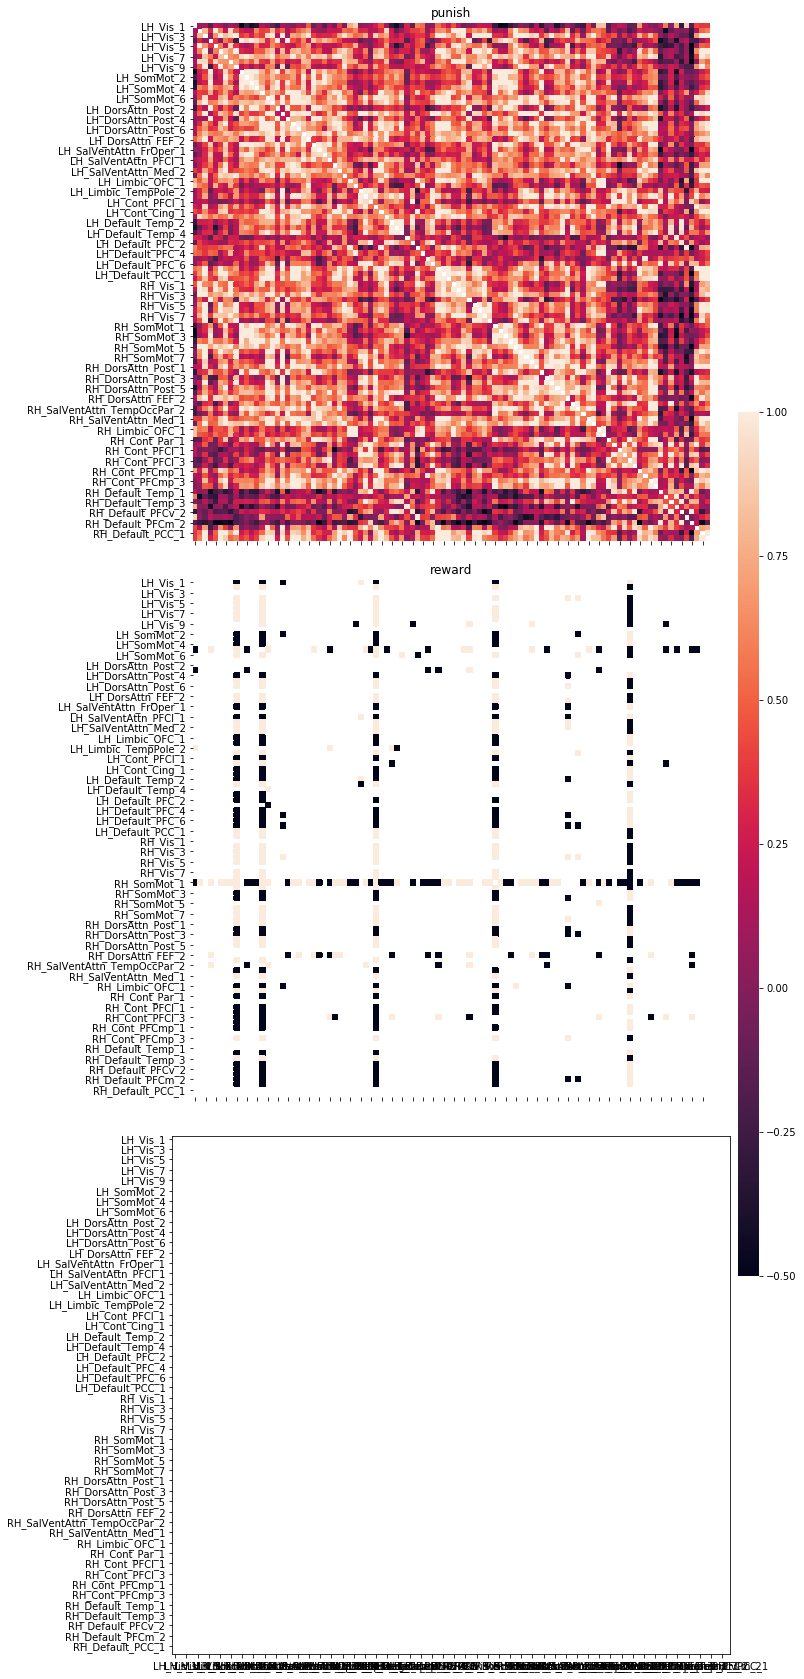

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 30),
                         gridspec_kw={'wspace': 0.025, 'hspace': 0.075})

cbar_ax = fig.add_axes([.91, .3, .03, .4])
r = 0
for trial_type, df in pd_dict.items():
    g = sns.heatmap(df, ax=axes[r], vmin=-.5, vmax=1., square=True,
                    cbar=True, cbar_ax=cbar_ax)
    axes[r].set_title(trial_type)
    # iterate over rows
    r += 1
plt.tight_layout()